In [1]:
#housekeeping and essential imports
import pandas as pd
import os
import numpy as np
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
pd.set_option('display.max_rows', 500)
pd.set_option('display.width', 1200)
pd.set_option ('display.max_colwidth', 70)

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [195]:
DIR = os.path.join(os.path.expanduser("~"),"Downloads/denonovoPAStestoutput/")

In [196]:
DIR

'/Volumes/Storage/chaodai/Downloads/denonovoPAStestoutput/'

In [ ]:
# use dataframe to calculate unique counts

In [219]:
import glob
#grab all files ending with .bedA
filels = glob.glob(os.path.join(DIR, "*.bedA*"))

In [220]:
filels[0:5]
len(filels)

['/Volumes/Storage/chaodai/Downloads/denonovoPAStestoutput/F231chr20_62688324_62689008.bedA',
 '/Volumes/Storage/chaodai/Downloads/denonovoPAStestoutput/F231chr20_39987361_39989222.bedA',
 '/Volumes/Storage/chaodai/Downloads/denonovoPAStestoutput/F4175chr20_58563958_58564218.bedA',
 '/Volumes/Storage/chaodai/Downloads/denonovoPAStestoutput/F231chr20_34061694_34061877.bedA',
 '/Volumes/Storage/chaodai/Downloads/denonovoPAStestoutput/F231chr20_45606873_45607275.bedA']

408

In [225]:
os.chdir("/Volumes/Storage/chaodai/Downloads/denonovoPAStestoutput/")

In [226]:
filesize_ls=[]
for l in filels: 
    filesize_ls.append(os.path.getsize(l)) # get file size info

In [227]:
len(filesize_ls)
files = pd.DataFrame({"Name":filels, "Size":filesize_ls}) #dataframe to store file names(full path) and file size

408

In [228]:
filtered_files = files[files.Size >0] #filter through only files with size > 0, these are the files that have matches

In [229]:
filtered_files.reset_index(inplace=True, drop=True) # reset row index

In [230]:
filtered_files['dataset']  = filtered_files['Name'].str.extract('\w+output/(F\d+)\w+\.bedA$', expand=False) # extract dataset from file name

/Volumes/Storage/chaodai/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [232]:
filtered_files.head()
filtered_files.shape

,Name,Size,dataset
0,/Volumes/Storage/chaodai/Downloads/denonovoPAStestoutput/F231chr20...,105659,F231
1,/Volumes/Storage/chaodai/Downloads/denonovoPAStestoutput/F231chr20...,67,F231
2,/Volumes/Storage/chaodai/Downloads/denonovoPAStestoutput/F231chr20...,68,F231
3,/Volumes/Storage/chaodai/Downloads/denonovoPAStestoutput/F231chr20...,66,F231
4,/Volumes/Storage/chaodai/Downloads/denonovoPAStestoutput/F231chr20...,201,F231


(153, 3)

In [233]:
filtered_files['Name'][0]

'/Volumes/Storage/chaodai/Downloads/denonovoPAStestoutput/F231chr20_39987361_39989222.bedA'

 ## get reads per utr region

In [238]:
total_reads=[] #store reads per utr region
df2=pd.DataFrame([]) # store results from all files into one dataframe
for i in range(0,len(filtered_files)):
    df = pd.read_csv(os.path.join(DIR, filtered_files['Name'][i]), sep=" ", header=None) # read all files with size > 0
    df.columns = ["ref_chromosome", "ref_start", "ref_end", "transcript_id", "strand", "gene", "read_chromosome", "read_start", "read_end"] # name columns
    df['dataset'] = filtered_files['dataset'][i] # add dataset info
    total_reads = df.groupby(["ref_start", "ref_end"])['read_start'].count() # add reads per utr region as column
    df['reads_per_utr'] = total_reads[0]
    df2 = pd.concat([df2, df]) # process all files (dataframes) and combine into one dataframe
    total_reads=[] # this is temprorary for the iteration

In [239]:
df2.reset_index(drop=True, inplace=True)

In [263]:
df2.head() #Note df2 has duplicats because it flattens content from all files into one dataframe


,ref_chromosome,ref_start,ref_end,transcript_id,strand,gene,read_chromosome,read_start,read_end,dataset,reads_per_utr
0,chr20,39987361,39989222,uc010zwf.2,+,LPIN3,chr20,39978147,39989222,F231,1577
1,chr20,39987361,39989222,uc010zwf.2,+,LPIN3,chr20,39978151,39988962,F231,1577
2,chr20,39987361,39989222,uc010zwf.2,+,LPIN3,chr20,39978151,39989221,F231,1577
3,chr20,39987361,39989222,uc010zwf.2,+,LPIN3,chr20,39978151,39989216,F231,1577
4,chr20,39987361,39989222,uc010zwf.2,+,LPIN3,chr20,39978151,39988562,F231,1577


In [278]:
df2[df2.reads_per_utr >= 50][['ref_chromosome', 'ref_start', 'ref_end', 'transcript_id', 'strand']].drop_duplicates()

,ref_chromosome,ref_start,ref_end,transcript_id,strand
0,chr20,39987361,39989222,uc010zwf.2,+
1659,chr20,62521395,62522898,uc021wgg.1,+
2663,chr20,18123001,18123812,uc021wba.1,+
2896,chr20,62329994,62332034,uc011abf.3,-
3203,chr20,61598134,61599947,uc011aap.1,+
3286,chr20,34099455,34099803,uc010zve.2,+
3447,chr20,42697289,42698254,uc031rtm.1,+
3516,chr20,60869013,60871269,uc011aah.1,+
3825,chr20,57485737,57486250,uc021wfl.1,+
9080,chr20,32676114,32677450,uc031rsu.1,-


#### Histogram data for reads_per_utr

In [243]:
hist_col = ['ref_chromosome', 'ref_start', 'ref_end', 'transcript_id', 'strand', 'dataset', 'reads_per_utr'] #columns for the histogram data

In [244]:
hist_data = df2[hist_col].drop_duplicates().sort_values(by=['dataset','ref_start', 'ref_end']).reset_index(drop=True) #get unique count (reads_per_utr) for each utr region

In [174]:
#hist_data.to_csv("hist_data.csv", index=False, sep="\t", header=True) #export to csv

In [246]:
hist_data.shape
hist_data.head()

(153, 7)

,ref_chromosome,ref_start,ref_end,transcript_id,strand,dataset,reads_per_utr
0,chr20,3190005,3190263,uc031rsf.1,+,F231,5
1,chr20,9459656,9461462,uc021wam.1,+,F231,6
2,chr20,18123001,18123812,uc021wba.1,+,F231,156
3,chr20,23356709,23358012,uc010zss.1,-,F231,3
4,chr20,24943579,24944636,uc010zsw.2,-,F231,709


In [287]:
hist_data[hist_data.reads_per_utr >= 50].head()

,ref_chromosome,ref_start,ref_end,transcript_id,strand,dataset,reads_per_utr
2,chr20,18123001,18123812,uc021wba.1,+,F231,156
4,chr20,24943579,24944636,uc010zsw.2,-,F231,709
10,chr20,25426558,25429191,uc010zte.1,+,F231,66
16,chr20,32676114,32677450,uc031rsu.1,-,F231,4545
17,chr20,33148345,33148783,uc010zul.2,-,F231,155


In [299]:
names = hist_data[hist_data.reads_per_utr >= 50][['ref_chromosome', 'ref_start', 'ref_end', 'dataset']].drop_duplicates()

In [308]:
names.shape
names.head()
names.dtypes
filtered_files.Name[0]

(34, 4)

,ref_chromosome,ref_start,ref_end,dataset
2,chr20,18123001,18123812,F231
4,chr20,24943579,24944636,F231
10,chr20,25426558,25429191,F231
16,chr20,32676114,32677450,F231
17,chr20,33148345,33148783,F231


ref_chromosome    object
ref_start          int64
ref_end            int64
dataset           object
dtype: object

'/Volumes/Storage/chaodai/Downloads/denonovoPAStestoutput/F231chr20_39987361_39989222.bedA'

In [322]:
filtered_bedA_files = names['dataset'] + names['ref_chromosome'] + '_' + names['ref_start'].map(str) + '_' + names['ref_end'].map(str) + '.bedA'

In [325]:
os.getcwd()

'/Volumes/Storage/chaodai/Downloads/denonovoPAStestoutput'

In [326]:
filtered_bedA_files.to_csv(os.path.join("/Volumes/Storage/chaodai/Downloads/denonovoPAStestoutput", "filtered_bedA_files.csv"), sep="\t", index=False, header=None)

In [261]:
hist_data[hist_data.dataset.isin(['F231'])].reads_per_utr.describe()

count      81.000000
mean      207.185185
std       787.462001
min         1.000000
25%         1.000000
50%         5.000000
75%        30.000000
max      5152.000000
Name: reads_per_utr, dtype: float64

In [189]:
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import ticker
plt.style.use('seaborn-whitegrid')
from scipy import stats

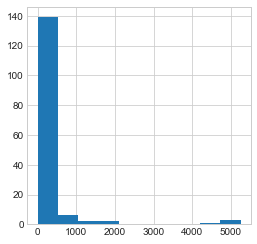

In [250]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4,4))
ax.hist(hist_data.reads_per_utr)
plt.show();

## Section II. Find Peaks

In [717]:
DIR2 = os.path.join(os.path.expanduser("~"),"GoogleDrive/NYU/Lab/denovoPASbedC")

In [718]:
def readFilesToDF(file_path, name_pat, sep=' ', header=None, skipinitialspace=True):
    """read bed files into one dataframe"""
    import glob
    glob.glob(os.path.join(file_path, name_pat))
    
    files = pd.DataFrame(glob.glob(os.path.join(file_path, name_pat)), columns=['full_path'])
    files['dataset'] = files['full_path'].str.extract('\w+/(F\d+)\w+', expand=False)
    files['file_name'] = files['full_path'].str.extract('\w+/(F\d+\w+\.\w+)', expand=False)
    bedC1 = pd.DataFrame([])
    for i in range(len(files.full_path)):
        bedC2 = pd.read_csv(files.full_path[i], sep=sep, header=header, skipinitialspace=skipinitialspace)
        bedC2[9] = files.dataset[i]
        bedC1 = pd.concat([bedC1, bedC2])
        bedC2 = pd.DataFrame([])
    return bedC1

In [719]:
bedC = readFilesToDF(file_path=DIR2, name_pat="*.bedC") # read all the bedC files.
# add column names
bedC.columns = ['reads_per_pos', 'utr_chromosome', 'utr_start', 'utr_end', 'transcript_id', 'strand', 'gene', 'read_chromosome', 'read_pos', 'dataset' ]

In [720]:
#calculating sum of reads for each utr region
bedC_sumofreads = bedC.groupby(['utr_chromosome', 'utr_start', 'utr_end', 'transcript_id', 'dataset'])['reads_per_pos'].sum() #groupby utr_region and calc sum
bedC_sumofreads = bedC_sumofreads.reset_index() #remove old index
bedC_sumofreads.rename(columns={'reads_per_pos':'sum_of_reads'}, inplace=True) #rename column

# joining bedC with sum table to incorporate calculated sum per utr region, calculate % of reads per loci 
bedC = pd.merge(bedC, bedC_sumofreads, how="left", on=['utr_chromosome', 'utr_start', 'utr_end', 'transcript_id', 'dataset'])  
bedC['concentration'] = bedC['reads_per_pos'] / bedC['sum_of_reads']
bedC['filter1'] = bedC.apply(lambda row: 'IN' if row.concentration >= 0.05 else 'OUT', axis=1 )

#### *Plotting Histograms*

In [724]:
# get unique list of utr regions
utr_regions = bedC[['utr_chromosome', 'utr_start', 'utr_end']].drop_duplicates()
utr_regions.reset_index(inplace=True, drop=True)
utr_regions.shape
utr_regions.head(2)

(18, 3)

,utr_chromosome,utr_start,utr_end
0,chr20,32676114,32677450
1,chr20,62703533,62703700


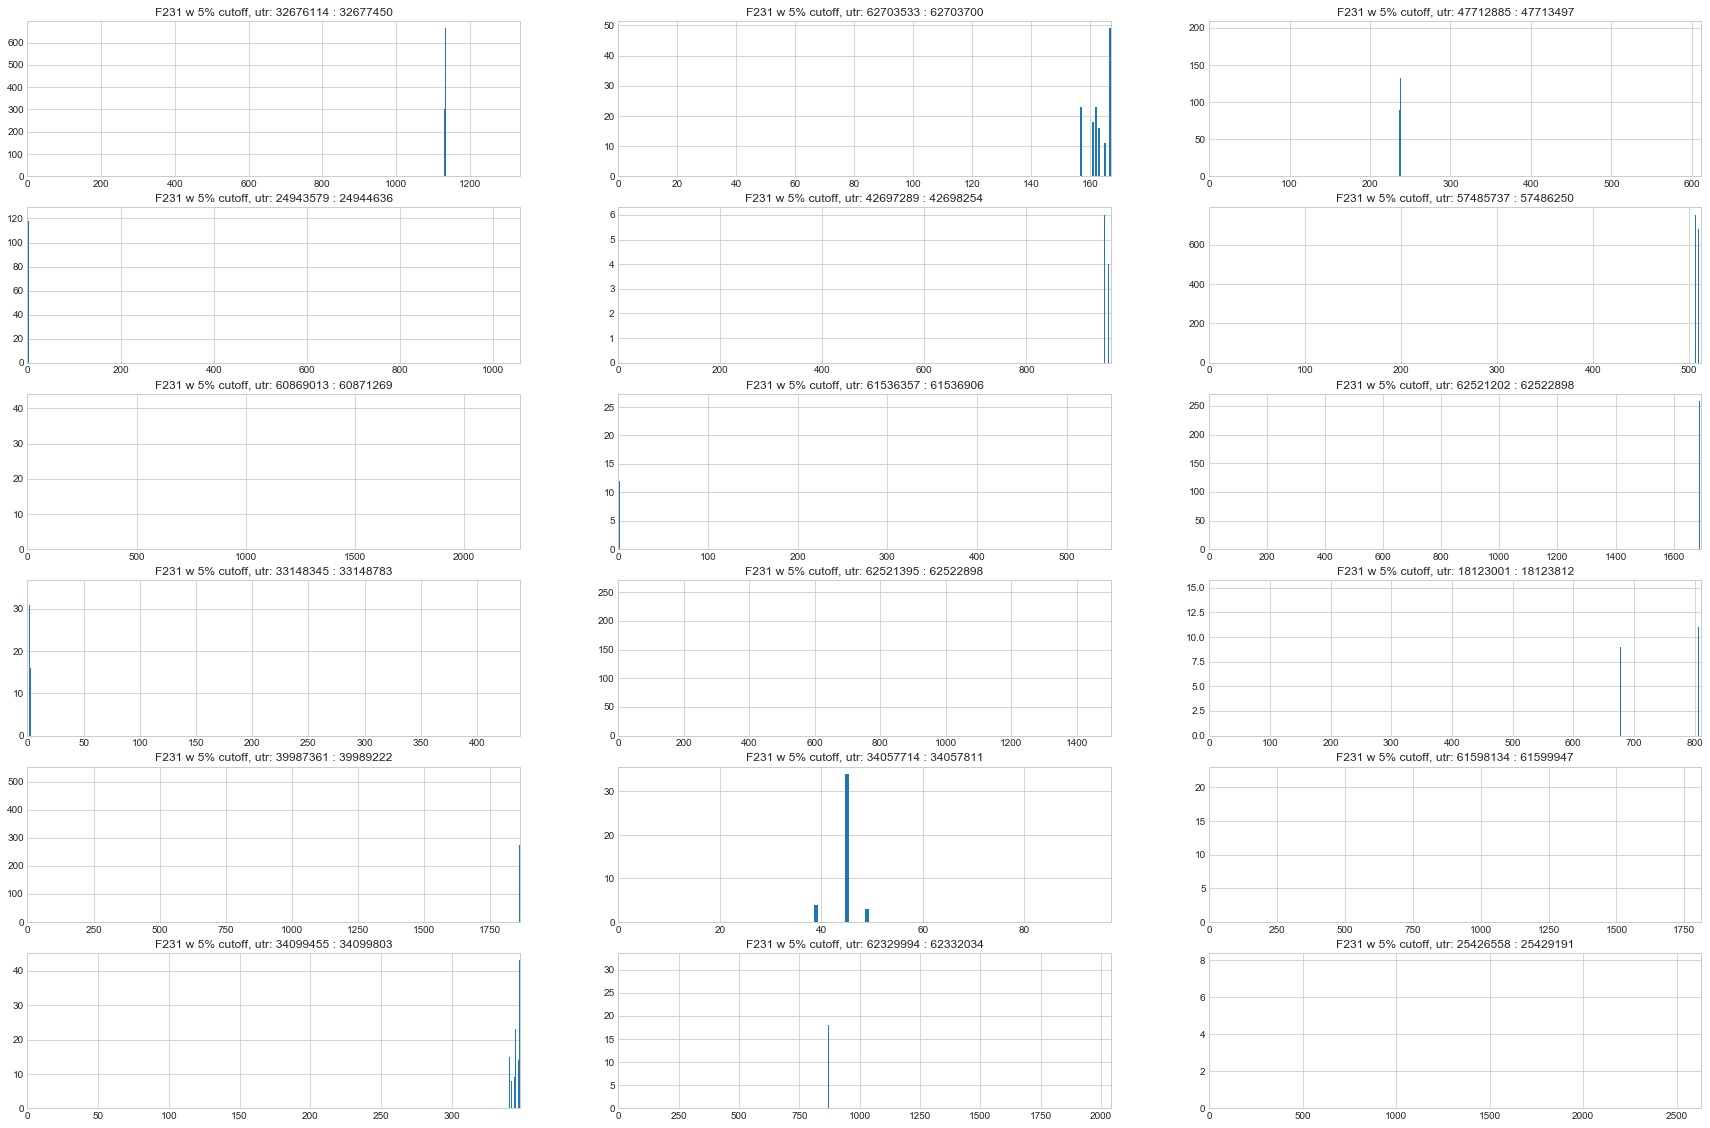

In [725]:
#plotting histograms
fig, ax = plt.subplots(nrows=6, ncols=3, figsize=(30,20))
ax_ls = list(ax.flatten())
x=[]
y=[]
#ax.get_xaxis().get_major_formatter().set_scientific(False)
for i in range(0,18):
    plot_data = bedC[(bedC.dataset.isin(['F231'])) & (bedC.utr_start == utr_regions.utr_start[i]) & (bedC.utr_end == utr_regions.utr_end[i]) & (bedC.filter1.isin(['IN']))]
    #print(len(plot_data['utr_end']))
    if not plot_data.empty:
        ax_ls[i].bar(x=abs(plot_data.read_pos - plot_data.utr_start), height=plot_data.reads_per_pos)
        ax_ls[i].set_title("F231 w 5% cutoff, utr: " + str(utr_regions.utr_start[i]) + " : " + str(utr_regions.utr_end[i]))
        ax_ls[i].set_xlim(left=0, right=max(plot_data.utr_end)- min(plot_data.utr_start))
    else:
        #ax_ls[i].bar(x=abs(plot_data.read_pos - plot_data.utr_start), height=plot_data.reads_per_pos)
        ax_ls[i].set_title("F231 w 5% cutoff, utr: " + str(utr_regions.utr_start[i]) + " : " + str(utr_regions.utr_end[i]))
        ax_ls[i].set_xlim(0,10)
        ax_ls[i].set_ylim(0,10)
        ax_ls[i].text(2, 6, r'No expression', fontsize=12, color='r')
    #ax2.get_xaxis().get_ma
    #ax2.set_xlim()
    
    plot_data=pd.DataFrame([])


#plt.show()
plt.savefig("/Volumes/Storage/chaodai/Desktop/fig4.pdf", dpi=300, format='pdf');

In [726]:
#view data
bedC[(bedC.dataset.isin(['F231'])) & (bedC.utr_start == 25426558) & (bedC.utr_end == 25429191)].sort_values(by=['concentration'],ascending=False)

,reads_per_pos,utr_chromosome,utr_start,utr_end,transcript_id,strand,gene,read_chromosome,read_pos,dataset,sum_of_reads,concentration,filter1
7656,8,chr20,25426558,25429191,uc010zte.1,+,GINS1,chr20,25429191,F231,66,0.121212,IN
7654,3,chr20,25426558,25429191,uc010zte.1,+,GINS1,chr20,25429189,F231,66,0.045455,OUT
7652,3,chr20,25426558,25429191,uc010zte.1,+,GINS1,chr20,25429187,F231,66,0.045455,OUT
7655,2,chr20,25426558,25429191,uc010zte.1,+,GINS1,chr20,25429190,F231,66,0.030303,OUT
7653,2,chr20,25426558,25429191,uc010zte.1,+,GINS1,chr20,25429188,F231,66,0.030303,OUT
7651,2,chr20,25426558,25429191,uc010zte.1,+,GINS1,chr20,25429185,F231,66,0.030303,OUT
7627,2,chr20,25426558,25429191,uc010zte.1,+,GINS1,chr20,25428883,F231,66,0.030303,OUT
7633,2,chr20,25426558,25429191,uc010zte.1,+,GINS1,chr20,25429093,F231,66,0.030303,OUT
7641,1,chr20,25426558,25429191,uc010zte.1,+,GINS1,chr20,25429139,F231,66,0.015152,OUT
7635,1,chr20,25426558,25429191,uc010zte.1,+,GINS1,chr20,25429095,F231,66,0.015152,OUT


---

### *Approach 1. Using ranks*

1. Rank each 

In [727]:
bedC.head()

,reads_per_pos,utr_chromosome,utr_start,utr_end,transcript_id,strand,gene,read_chromosome,read_pos,dataset,sum_of_reads,concentration,filter1
0,12,chr20,32676114,32677450,uc031rsu.1,-,EIF2S2,chr20,32676114,F231,4545,0.00264,OUT
1,3,chr20,32676114,32677450,uc031rsu.1,-,EIF2S2,chr20,32676115,F231,4545,0.00066,OUT
2,2,chr20,32676114,32677450,uc031rsu.1,-,EIF2S2,chr20,32676116,F231,4545,0.00044,OUT
3,8,chr20,32676114,32677450,uc031rsu.1,-,EIF2S2,chr20,32676117,F231,4545,0.00176,OUT
4,3,chr20,32676114,32677450,uc031rsu.1,-,EIF2S2,chr20,32676118,F231,4545,0.00066,OUT
